### We are Building MLP from Scratch using Pytorch

### import lib

In [2]:
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

### Dataset 


In [19]:
import kagglehub
import shutil
import os

# Download dataset
path = kagglehub.dataset_download("shantanuss/banknote-authentication-uci")

# Optionally copy to your desired location
desired_path = "./data/banknote_auth"
os.makedirs(desired_path, exist_ok=True)
for file in os.listdir(path):
    shutil.copy2(os.path.join(path, file), desired_path)

print("Dataset copied to:", desired_path)

df = pd.read_csv("./data/banknote_auth/BankNoteAuthentication.csv")

df.columns

Dataset copied to: ./data/banknote_auth


Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')

### EDA

In [ ]:
df.describe() # it may be a balanced dataset 44% class 1

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [ ]:
df.info() # there is no categrical values 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


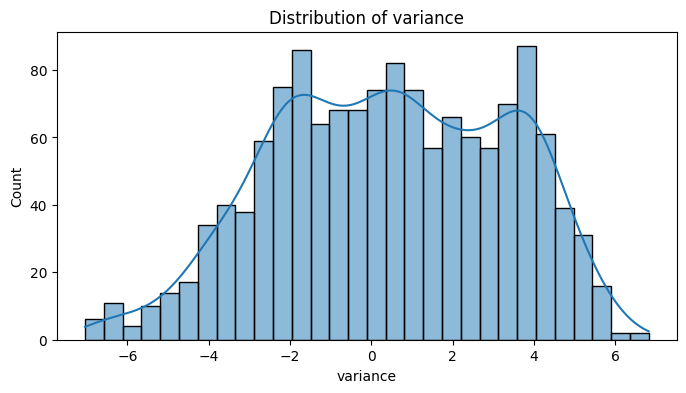

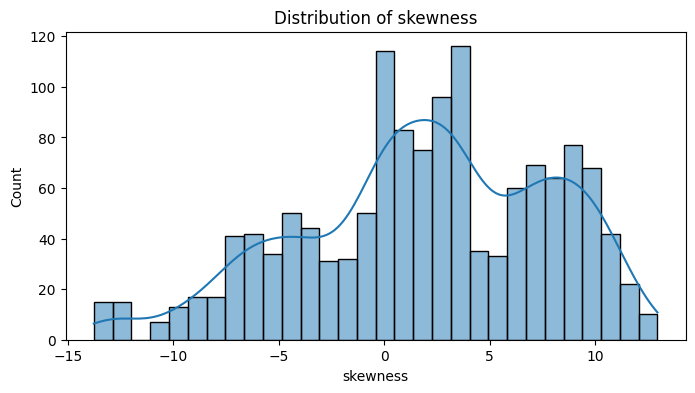

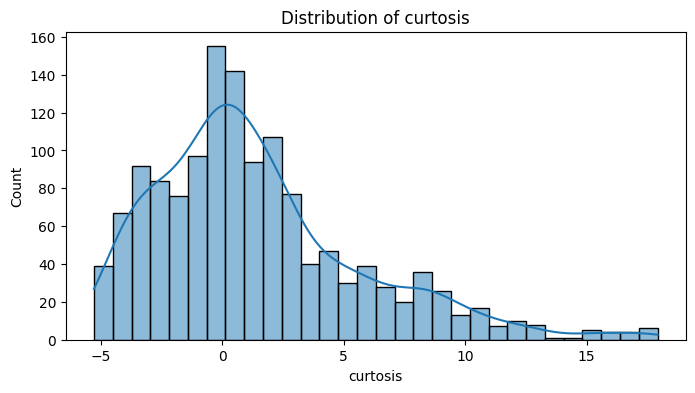

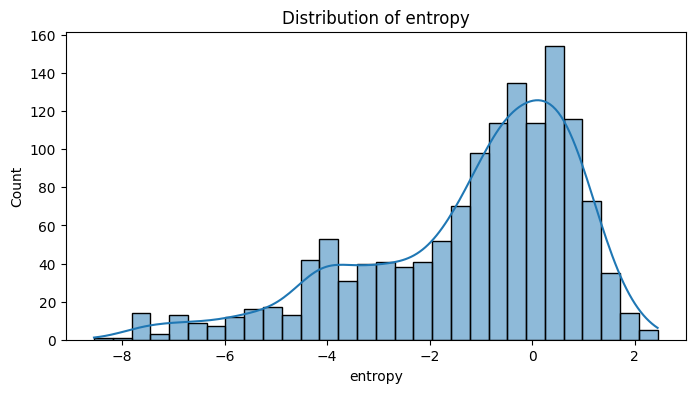

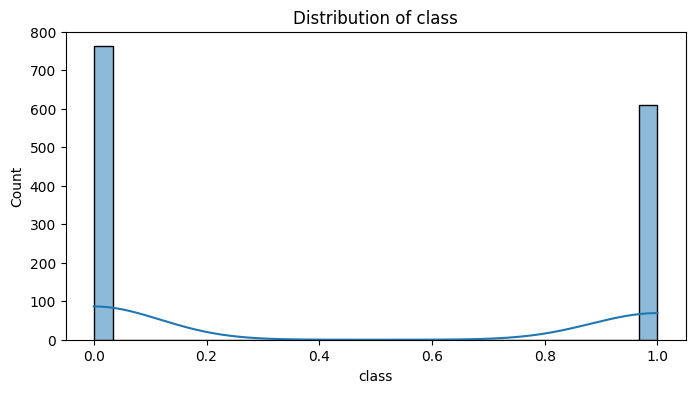

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

features = df.columns

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


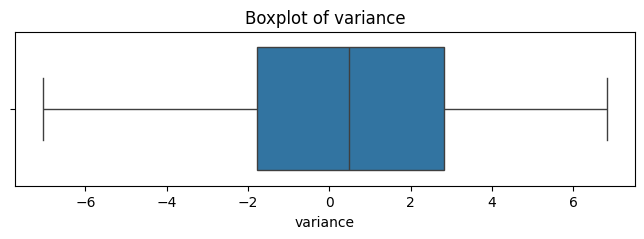

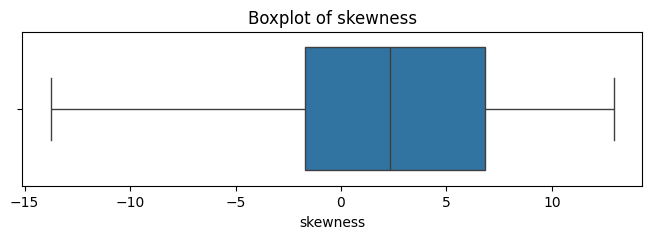

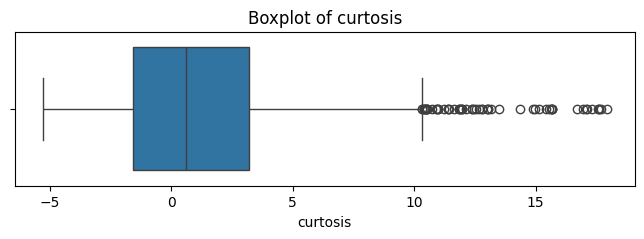

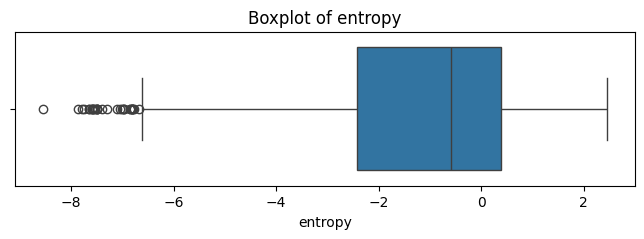

In [17]:
for feature in features:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


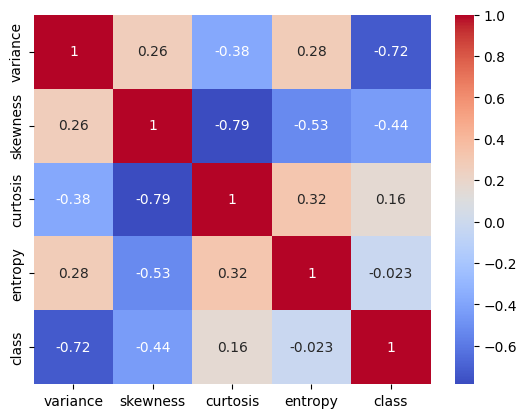

In [24]:
plt.Figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df.isnull().sum() # there is no null values 

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [ ]:
df['class'].value_counts(normalize=True)*100  # is not really imbalanced 

class
0    55.539359
1    44.460641
Name: proportion, dtype: float64

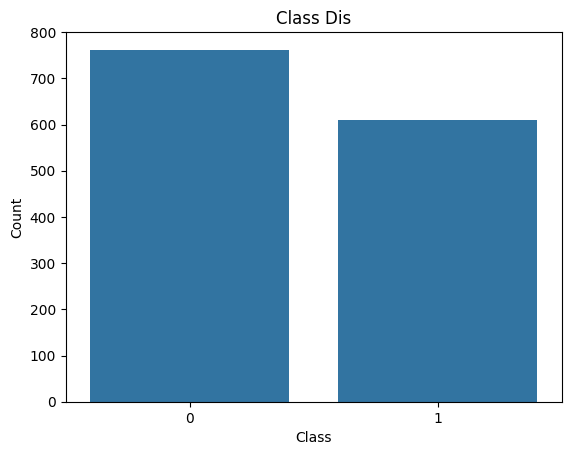

In [30]:
sns.countplot(x='class', data=df)
plt.title("Class Dis")
plt.xlabel('Class')
plt.ylabel("Count")
plt.show()

### Data preprocessing 

In [ ]:
y = df.iloc[:,-1:]
x = df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

type(y_train) # i have to convert it to numpy

pandas.core.frame.DataFrame

### Building the MLP

In [59]:
X_train_tensor = torch.tensor(X_train, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype= torch.float32)

X_test_tensor = torch.tensor(X_test, dtype= torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype= torch.float32)

class MLP(nn.Module):
    def __init__(self): # 16 -> 8 -> 1 
        super().__init__()
        self.fc1 = nn.Linear(4, 16)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, 8) 
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(8, 1) # there is no sigmoid here
    
    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return self.fc3(x) 


### Training 

In [61]:
model = MLP()
criterion = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss =[]
e = 500
for epoch in range(e):
    model.train()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    train_loss.append(loss.item())
    
    if epoch % 50 == 0:
        print(f'Epoch = {epoch}, loss: {loss.item():.4f}')
    

Epoch = 0, loss: 0.7042
Epoch = 50, loss: 0.6432
Epoch = 100, loss: 0.5809
Epoch = 150, loss: 0.5211
Epoch = 200, loss: 0.4842
Epoch = 250, loss: 0.4572
Epoch = 300, loss: 0.4540
Epoch = 350, loss: 0.4377
Epoch = 400, loss: 0.4423
Epoch = 450, loss: 0.4343


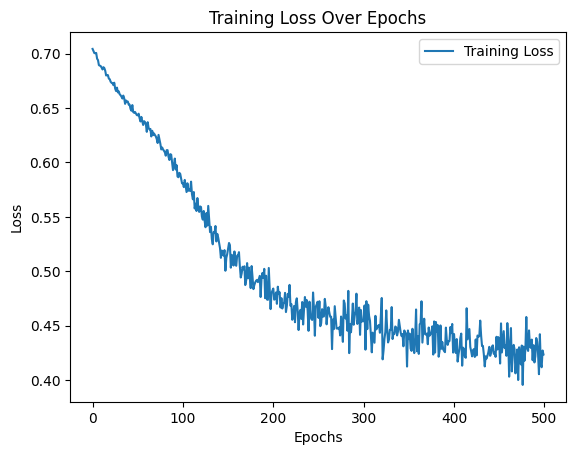

In [62]:
plt.plot(range(len(train_loss)), train_loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

### Evaluation 

In [65]:
model.eval()

with torch.no_grad():
    input = model(X_test_tensor)
    preds = torch.sigmoid(input)
    predicted_classes = (preds >= 0.5).float()

print("Accuracy: ", accuracy_score(y_test, predicted_classes))
print("Confusion Matrix: \n", confusion_matrix(y_test, predicted_classes))
print("Classification Report: ", classification_report(y_test, predicted_classes))


Accuracy:  0.8945454545454545
Confusion Matrix: 
 [[135  18]
 [ 11 111]]
Classification Report:                precision    recall  f1-score   support

           0       0.92      0.88      0.90       153
           1       0.86      0.91      0.88       122

    accuracy                           0.89       275
   macro avg       0.89      0.90      0.89       275
weighted avg       0.90      0.89      0.89       275

